In [1]:
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input, decode_predictions
import numpy as np
from keras.preprocessing import image
import operator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from keras import models, layers, optimizers
from keras.utils import multi_gpu_model
from keras.models import load_model
import warnings

warnings.filterwarnings('ignore')
folders = ["birds/toucan/tou", "birds/egret/egr", "birds/mandarin/man", "birds/wood_duck/wod", "birds/puffin/puf", 
           "birds/owl/owl"]
birds = ["toucan", "American_egret", "mandarin", "wood_duck", "puffin", "owl"]

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
model = MobileNet(weights='imagenet')

In [3]:
def predict(img_path):    
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return decode_predictions(preds, top=3)[0][0][1]

In [4]:
d = {}
for i in range(6):
    for j in range(1,101):
        s = predict(folders[i]+str(j).zfill(3)+".jpg")
        if s in d:
            d[s] += 1
        else:
            d[s] = 1

In [5]:
sd = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
ten = []
for i in range(min(len(sd), 10)):
    ten.append(sd[i][0])

In [6]:
true = []
pred = []
for i in range(6):
    for j in range(1,101):
        s = predict(folders[i]+str(j).zfill(3)+".jpg")
        if s in ten:
            pred.append(s)
        else:
            pred.append("other")
        true.append(birds[i])

In [7]:
for j in range(6):
    for i in range(j*100,(j+1)*100):
        print(true[i], "\t", pred[i])

toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	 toucan
toucan 	

In [8]:
def plot_confusion_matrix(cm, xclasses, yclasses, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    xtick_marks = np.arange(len(xclasses))
    ytick_marks = np.arange(len(yclasses))
    plt.xticks(xtick_marks, xclasses, rotation=90)
    plt.yticks(ytick_marks, yclasses)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 0 91  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  1 80  0  0  0  0 18  0  0  0  0  1  0]
 [18  0  4  0 14  0  0  0 37  0 27  0  0  0  0]
 [ 0  0 16 12  0  8 18  0 19  0  1  0 20  6  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0 97  0  0]
 [ 0  0  0 97  0  0  1  0  2  0  0  0  0  0  0]]


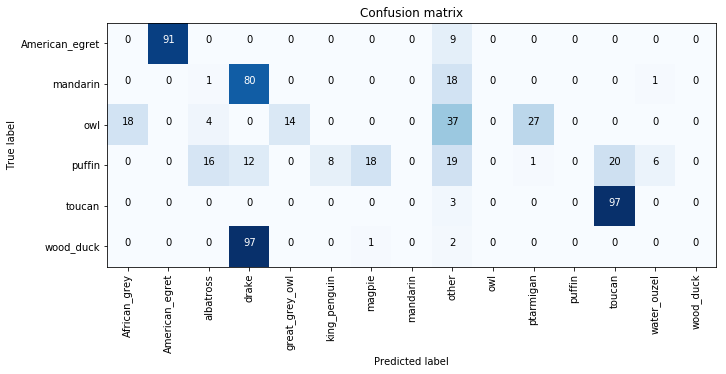

In [9]:
cnf_matrix = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
s = set()
for i in ten:
    s.add(i)
for i in birds:
    s.add(i)
s.add("other")
l = sorted(list(s))
indices = []
for i in range(len(l)):
    if l[i] in birds:
        indices.append(i)
plot_confusion_matrix(np.array([[x for x in cnf_matrix[y]] for y in indices]), yclasses=sorted(birds), xclasses=l,
                     normalize=False)

# Train model with no trainable mobilenet layers
## Train Model without removing layers

In [11]:
training = 71
validation = 101
birdsNum = 6
epochs = 150
batch_size = 32
def loadImage(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)    
    return preprocess_input(x)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [5]:
model2 = models.Sequential()
model2.add(model)

model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

for layer in model2.layers[:-2]:
    layer.trainable = False
    
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              4253864   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               256256    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 4,511,662
Trainable params: 257,798
Non-trainable params: 4,253,864
_________________________________________________________________


In [6]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [19]:
x, y, vx, vy = [], [], [], []

for i in range(birdsNum):
    for j in range(1,training):
        x.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        y.append(i)
        
for i in range(birdsNum):
    for j in range(training,validation):
        vx.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        vy.append(i)

x = np.array(x)
y = np.array(y)
vy = np.array(vy)
vx = np.array(vx)
v = (vx, vy)

In [22]:
history = model2.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=v)

Train on 420 samples, validate on 180 samples
Epoch 1/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5790 - acc: 0.5738 - val_loss: 1.3115 - val_acc: 0.7111
Epoch 2/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5773 - acc: 0.5667 - val_loss: 1.3081 - val_acc: 0.7056
Epoch 3/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5706 - acc: 0.4952 - val_loss: 1.3043 - val_acc: 0.7167
Epoch 4/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5696 - acc: 0.5381 - val_loss: 1.3012 - val_acc: 0.7444
Epoch 5/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5549 - acc: 0.5833 - val_loss: 1.2978 - val_acc: 0.7167
Epoch 6/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5664 - acc: 0.5833 - val_loss: 1.2943 - val_acc: 0.7444
Epoch 7/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5654 - acc: 0.5476 - val_loss: 1.2909 - val_acc: 0.7500
Epoch 8/150
420/420 [==

Epoch 62/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4877 - acc: 0.6905 - val_loss: 1.1489 - val_acc: 0.7611
Epoch 63/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4649 - acc: 0.7286 - val_loss: 1.1472 - val_acc: 0.7556
Epoch 64/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4727 - acc: 0.6810 - val_loss: 1.1453 - val_acc: 0.7556
Epoch 65/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4722 - acc: 0.7167 - val_loss: 1.1436 - val_acc: 0.7500
Epoch 66/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4796 - acc: 0.6714 - val_loss: 1.1414 - val_acc: 0.7556
Epoch 67/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4743 - acc: 0.6452 - val_loss: 1.1402 - val_acc: 0.7500
Epoch 68/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4708 - acc: 0.7000 - val_loss: 1.1387 - val_acc: 0.7611
Epoch 69/150
420/420 [==============================] - 1s 3ms

Epoch 123/150
420/420 [==============================] - 1s 3ms/step - loss: 1.3972 - acc: 0.6262 - val_loss: 1.0559 - val_acc: 0.7389
Epoch 124/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4037 - acc: 0.6286 - val_loss: 1.0542 - val_acc: 0.7389
Epoch 125/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4124 - acc: 0.6214 - val_loss: 1.0542 - val_acc: 0.7333
Epoch 126/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4040 - acc: 0.5833 - val_loss: 1.0533 - val_acc: 0.7278
Epoch 127/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4023 - acc: 0.6262 - val_loss: 1.0523 - val_acc: 0.7222
Epoch 128/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4094 - acc: 0.5762 - val_loss: 1.0518 - val_acc: 0.7222
Epoch 129/150
420/420 [==============================] - 1s 3ms/step - loss: 1.3895 - acc: 0.6095 - val_loss: 1.0493 - val_acc: 0.7278
Epoch 130/150
420/420 [==============================] 

Text(0,0.5,'Loss')

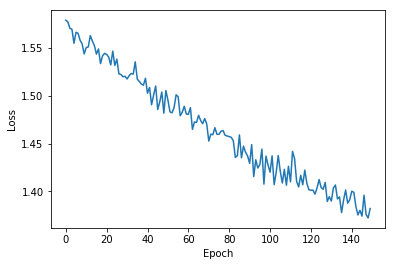

In [24]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [25]:
score = model2.evaluate(vx, vy, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0317444642384848
Test accuracy: 0.75


### Saving and Loading Model

In [27]:
model2.save_weights("model1.h5")

In [7]:
model2.load_weights(filepath='model1.h5')

### Confussion matrix

In [9]:
def getPredicted(pred):    
    c, m = 0, 0
    for i in range(pred.shape[1]):
        if pred[0][i] > m:
            m = pred[0][i]
            c = birds[i]
    return c

def predict2(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return getPredicted(model2.predict(x))

In [13]:
true = []
pred = []
for i in range(birdsNum):
    for j in range(training,validation):
        s = predict2(folders[i]+str(j).zfill(3)+".jpg")
        pred.append(s)
        true.append(birds[i]) 

Confusion matrix, without normalization
[[30  0  0  0  0  0]
 [ 0  1  1  0  0 28]
 [ 0  0 30  0  0  0]
 [ 0  0  2 15  7  6]
 [ 0  0  0  0 30  0]
 [ 0  0  0  1  0 29]]


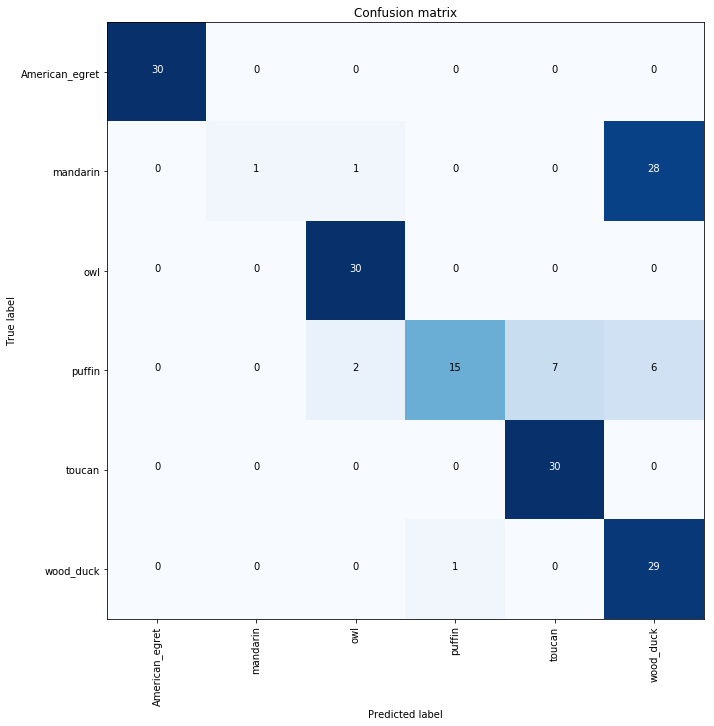

In [14]:
cnf_matrix = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, yclasses=sorted(birds), xclasses=sorted(birds), normalize=False)

# Train Model removing 2 layers till convolutional layer

In [15]:
model.layers.pop()
model.layers.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [16]:
model2 = models.Sequential()
model2.add(model)

model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

for layer in model2.layers[:-2]:
    layer.trainable = False
    
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              4253864   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               256256    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 4,511,662
Trainable params: 257,798
Non-trainable params: 4,253,864
_________________________________________________________________


In [21]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [71]:
x, y, vx, vy = [], [], [], []

for i in range(birdsNum):
    for j in range(1,training):
        x.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        y.append(i)
        
for i in range(birdsNum):
    for j in range(training,validation):
        vx.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        vy.append(i)

x = np.array(x)
y = np.array(y)
vy = np.array(vy)
vx = np.array(vx)
v = (vx, vy)

In [75]:
history = model2.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=v)

Train on 420 samples, validate on 180 samples
Epoch 1/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5678 - acc: 0.5452 - val_loss: 1.3260 - val_acc: 0.6278
Epoch 2/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5611 - acc: 0.6000 - val_loss: 1.3234 - val_acc: 0.6333
Epoch 3/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5689 - acc: 0.6333 - val_loss: 1.3201 - val_acc: 0.6389
Epoch 4/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5700 - acc: 0.6357 - val_loss: 1.3167 - val_acc: 0.6333
Epoch 5/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5661 - acc: 0.6143 - val_loss: 1.3130 - val_acc: 0.6444
Epoch 6/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5509 - acc: 0.6048 - val_loss: 1.3099 - val_acc: 0.6444
Epoch 7/150
420/420 [==============================] - 1s 3ms/step - loss: 1.5492 - acc: 0.6000 - val_loss: 1.3063 - val_acc: 0.6500
Epoch 8/150
420/420 [==

Epoch 62/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4592 - acc: 0.5571 - val_loss: 1.1740 - val_acc: 0.6611
Epoch 63/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4701 - acc: 0.5667 - val_loss: 1.1718 - val_acc: 0.6444
Epoch 64/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4815 - acc: 0.5381 - val_loss: 1.1702 - val_acc: 0.6444
Epoch 65/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4714 - acc: 0.5524 - val_loss: 1.1678 - val_acc: 0.6444
Epoch 66/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4606 - acc: 0.5476 - val_loss: 1.1663 - val_acc: 0.6444
Epoch 67/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4582 - acc: 0.5429 - val_loss: 1.1647 - val_acc: 0.6444
Epoch 68/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4704 - acc: 0.5167 - val_loss: 1.1640 - val_acc: 0.6389
Epoch 69/150
420/420 [==============================] - 1s 3ms

Epoch 123/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4084 - acc: 0.7071 - val_loss: 1.0927 - val_acc: 0.6778
Epoch 124/150
420/420 [==============================] - 1s 3ms/step - loss: 1.3990 - acc: 0.7167 - val_loss: 1.0920 - val_acc: 0.6722
Epoch 125/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4048 - acc: 0.7238 - val_loss: 1.0899 - val_acc: 0.6722
Epoch 126/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4169 - acc: 0.6262 - val_loss: 1.0913 - val_acc: 0.6833
Epoch 127/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4013 - acc: 0.6976 - val_loss: 1.0901 - val_acc: 0.6667
Epoch 128/150
420/420 [==============================] - 1s 3ms/step - loss: 1.4156 - acc: 0.6452 - val_loss: 1.0915 - val_acc: 0.6722
Epoch 129/150
420/420 [==============================] - 1s 3ms/step - loss: 1.3824 - acc: 0.6238 - val_loss: 1.0909 - val_acc: 0.6778
Epoch 130/150
420/420 [==============================] 

Text(0,0.5,'Loss')

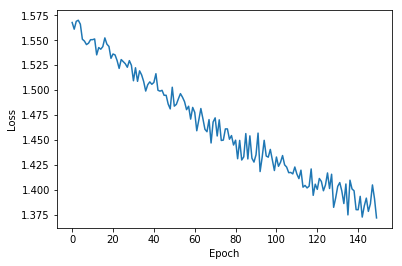

In [76]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [77]:
score = model2.evaluate(vx, vy, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0707918140623305
Test accuracy: 0.6888888902134366


### Saving and Loading Model

In [78]:
model2.save_weights("model2.h5")

In [22]:
model2.load_weights(filepath='model2.h5')

### Confusion Matrix

In [23]:
true = []
pred = []
for i in range(birdsNum):
    for j in range(training,validation):
        s = predict2(folders[i]+str(j).zfill(3)+".jpg")
        pred.append(s)
        true.append(birds[i]) 

Confusion matrix, without normalization
[[30  0  0  0  0  0]
 [ 0  2  0  0  0 28]
 [ 0  2 26  2  0  0]
 [ 0  9  0  7  8  6]
 [ 0  0  0  0 30  0]
 [ 0  1  0  0  0 29]]


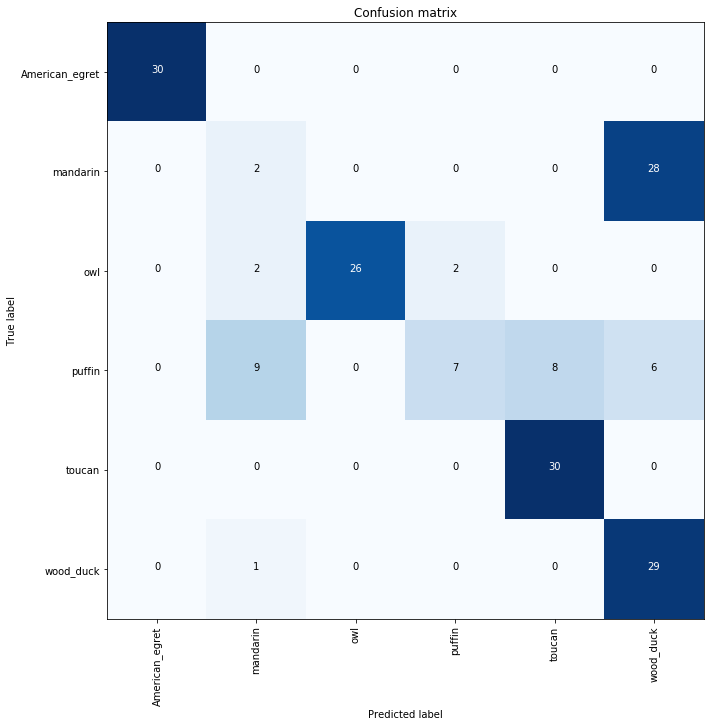

In [24]:
cnf_matrix = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, yclasses=sorted(birds), xclasses=sorted(birds), normalize=False)

# Training all the model

In [81]:
model2 = models.Sequential()
model2.add(model)

model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

for layer in model2.layers:
    layer.trainable = True
    print(layer, layer.trainable)
    
model2.summary()

<keras.engine.training.Model object at 0x7f982c96e9e8> True
<keras.layers.core.Dense object at 0x7f97fd0869b0> True
<keras.layers.core.Dense object at 0x7f97fd1257f0> True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              4253864   
_________________________________________________________________
dense_19 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 1542      
Total params: 4,511,662
Trainable params: 4,489,774
Non-trainable params: 21,888
_________________________________________________________________


In [82]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [83]:
x, y, vx, vy = [], [], [], []

for i in range(birdsNum):
    for j in range(1,training):
        x.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        y.append(i)
        
for i in range(birdsNum):
    for j in range(training,validation):
        vx.append(loadImage(folders[i]+str(j).zfill(3)+".jpg"))
        vy.append(i)

x = np.array(x)
y = np.array(y)
vy = np.array(vy)
vx = np.array(vx)
v = (vx, vy)

In [84]:
history = model2.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=v)

Train on 420 samples, validate on 180 samples
Epoch 1/150
420/420 [==============================] - 10s 23ms/step - loss: 1.7898 - acc: 0.1881 - val_loss: 1.7885 - val_acc: 0.2389
Epoch 2/150
420/420 [==============================] - 3s 7ms/step - loss: 1.7874 - acc: 0.2476 - val_loss: 1.7866 - val_acc: 0.2444
Epoch 3/150
420/420 [==============================] - 3s 7ms/step - loss: 1.7850 - acc: 0.2548 - val_loss: 1.7845 - val_acc: 0.2833
Epoch 4/150
420/420 [==============================] - 3s 7ms/step - loss: 1.7819 - acc: 0.2619 - val_loss: 1.7821 - val_acc: 0.3000
Epoch 5/150
420/420 [==============================] - 3s 8ms/step - loss: 1.7790 - acc: 0.3500 - val_loss: 1.7792 - val_acc: 0.3556
Epoch 6/150
420/420 [==============================] - 3s 8ms/step - loss: 1.7745 - acc: 0.4095 - val_loss: 1.7762 - val_acc: 0.3444
Epoch 7/150
420/420 [==============================] - 3s 7ms/step - loss: 1.7719 - acc: 0.4167 - val_loss: 1.7728 - val_acc: 0.3444
Epoch 8/150
420/420 [

Epoch 62/150
420/420 [==============================] - 3s 7ms/step - loss: 1.0894 - acc: 0.8833 - val_loss: 1.1405 - val_acc: 0.8111
Epoch 63/150
420/420 [==============================] - 3s 8ms/step - loss: 1.0718 - acc: 0.8619 - val_loss: 1.1245 - val_acc: 0.8056
Epoch 64/150
420/420 [==============================] - 3s 7ms/step - loss: 1.0568 - acc: 0.8762 - val_loss: 1.1068 - val_acc: 0.8111
Epoch 65/150
420/420 [==============================] - 3s 8ms/step - loss: 1.0398 - acc: 0.8619 - val_loss: 1.0909 - val_acc: 0.8111
Epoch 66/150
420/420 [==============================] - 3s 7ms/step - loss: 1.0267 - acc: 0.8619 - val_loss: 1.0761 - val_acc: 0.8111
Epoch 67/150
420/420 [==============================] - 3s 8ms/step - loss: 1.0092 - acc: 0.8619 - val_loss: 1.0583 - val_acc: 0.8111
Epoch 68/150
420/420 [==============================] - 3s 7ms/step - loss: 0.9923 - acc: 0.8548 - val_loss: 1.0428 - val_acc: 0.8111
Epoch 69/150
420/420 [==============================] - 3s 7ms

Epoch 123/150
420/420 [==============================] - 3s 7ms/step - loss: 0.4066 - acc: 0.8286 - val_loss: 0.4779 - val_acc: 0.8278
Epoch 124/150
420/420 [==============================] - 3s 8ms/step - loss: 0.4001 - acc: 0.8310 - val_loss: 0.4700 - val_acc: 0.8278
Epoch 125/150
420/420 [==============================] - 3s 7ms/step - loss: 0.3925 - acc: 0.8333 - val_loss: 0.4642 - val_acc: 0.8222
Epoch 126/150
420/420 [==============================] - 3s 8ms/step - loss: 0.3884 - acc: 0.8333 - val_loss: 0.4593 - val_acc: 0.8167
Epoch 127/150
420/420 [==============================] - 3s 8ms/step - loss: 0.3847 - acc: 0.8333 - val_loss: 0.4545 - val_acc: 0.8167
Epoch 128/150
420/420 [==============================] - 3s 8ms/step - loss: 0.3904 - acc: 0.8310 - val_loss: 0.4428 - val_acc: 0.8167
Epoch 129/150
420/420 [==============================] - 3s 8ms/step - loss: 0.3871 - acc: 0.8310 - val_loss: 0.4509 - val_acc: 0.8111
Epoch 130/150
420/420 [==============================] 

Text(0,0.5,'Loss')

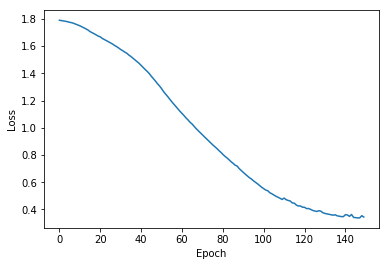

In [85]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [86]:
score = model2.evaluate(vx, vy, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.391882435977459
Test accuracy: 0.8111111111111111


### Saving and loading model

In [89]:
model2.save_weights("model3.h5")

In [ ]:
model2 = load_model('model3.h5')

In [87]:
true = []
pred = []
for i in range(birdsNum):
    for j in range(training,validation):
        s = predict2(folders[i]+str(j).zfill(3)+".jpg")
        pred.append(s)
        true.append(birds[i]) 

Confusion matrix, without normalization
[[100   0   0   0   0   0]
 [  0 100   0   0   0   0]
 [  1   0  98   1   0   0]
 [  1   0   0  99   0   0]
 [  0   0   1   2  97   0]
 [  0 100   0   0   0   0]]


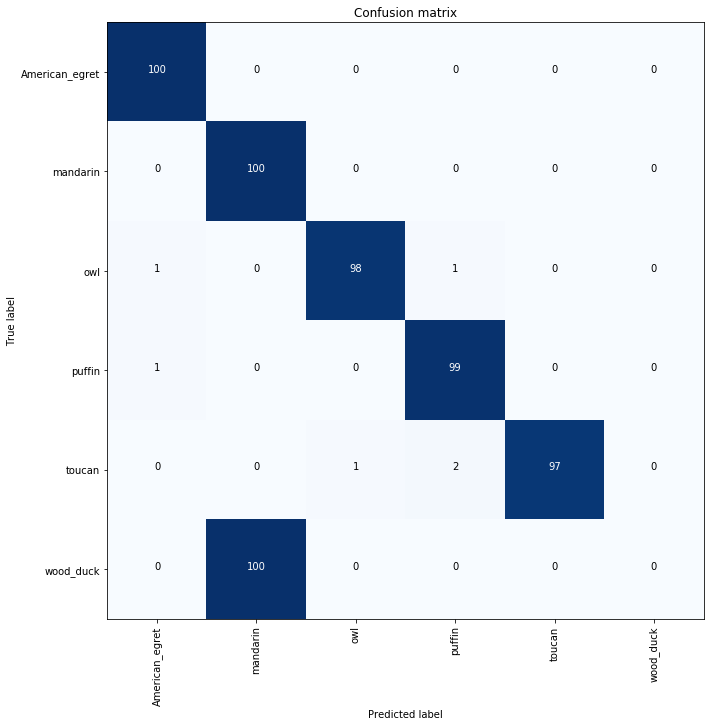

In [88]:
cnf_matrix = confusion_matrix(true, pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, yclasses=sorted(birds), xclasses=sorted(birds), normalize=False)